<a href="https://colab.research.google.com/github/royam0820/HuggingFace/blob/main/amr__RAG_langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Langchain
[LangChain](https://www.langchain.com/) is a python open-source library that provides all the elements needed to build an NLP application (precisely a Retrieval Augmented Generation) and link its various parts together in simple pipelines called chains.


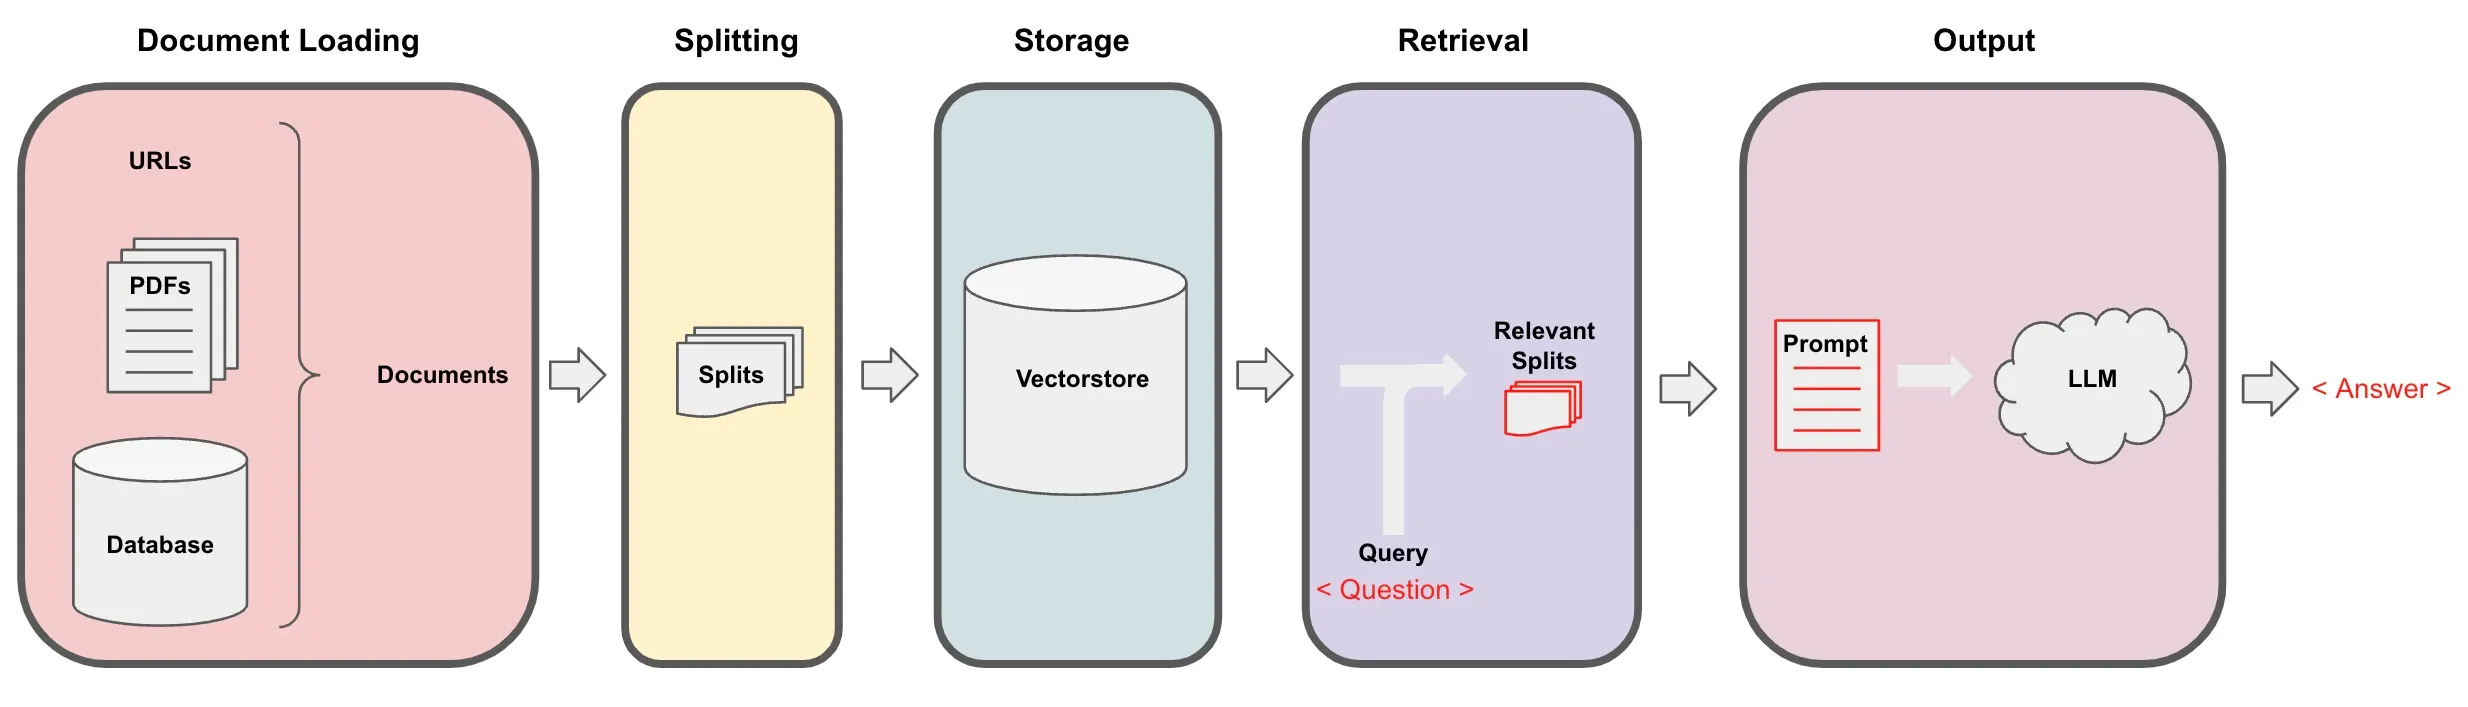

To achieve fine-tuning, LangChain offers APIs for two other entities:

- **Agents**: allow access to external resources to respond to a user request, for example other LLM or even private web services.

- **Index** allows private documents to be indexed (means stored) in diverse types of vector databases (more on this in a moment). The abstraction, in this case, concerns both the various types of documents to be acquired, and the many systems in which to persist them.

In summary, among LangChain’s distinctive features is the possibility of enriching a pre-trained LLM model with personal data that can be retrieved from documents such as pdfs, word processors or spreadsheets. But that’s not all: it is also possible to link to corporate databases or internal or public web services.



# Retrieval Augmented Generation (RAG)
Retrieval-Augmented Generation (RAG) is a framework that combines the strengths of both retrieval-based and generative methods for natural language understanding and generation. In a typical RAG setup, you have two main components: a retriever and a generator. Here's how they work together:

**Retriever**: When a query or prompt is received, the retriever component searches a large corpus of text to find relevant documents or passages. These are often called the "retrieved contexts".

**Generator**: The generator is a sequence-to-sequence model that takes both the original query and the retrieved contexts as input to generate a response or answer.

The core idea is to use the retriever to augment the generator with external knowledge, effectively combining the ability of retrieval-based models to access large stores of factual information with the nuanced, context-aware generation capabilities of sequence-to-sequence models.

## Setup

In [ ]:
# to fix the absence of utf-8 locale on Colab
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

NB: WARNING Re-start the run time.

In [ ]:
!pip install -qU transformers accelerate einops langchain xformers bitsandbytes faiss-gpu sentence_transformers pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.6/276.6 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.0 MB/s e

We can conclude the application setup by logging in.

In [ ]:
# logging to the HF hub to get access to the authentication token
from huggingface_hub import login
login()

## Loading a model

To load and execute the model, we will once again use the huggingface libraries.

In [ ]:
from torch import cuda, bfloat16
from transformers import AutoTokenizer,AutoModelForCausalLM,AutoConfig,BitsAndBytesConfig,pipeline


model_name = 'meta-llama/Llama-2-7b-chat-hf'

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    config=AutoConfig.from_pretrained(model_name),
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=bfloat16),
    device_map='cuda:0',
)
# enable model inference
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_name)

pipeline = pipeline(
    task='text-generation',
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,  # needed by langchain
    # model params
    max_new_tokens=512,
    temperature=0.1,  # creativity of responses: 0.0 none ->  1.0 max
    repetition_penalty=1.1  # to avoid repeating output
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Langchain pipeline

Here is how to use the huggingface runtime we have previously configured within LangChain:

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=pipeline)

#to query the model simply use langchain abstraction, as below
llm(prompt="what is the meaning of life?")

"\n nobody knows for sure, but here are some possible answers:\n\n1. To seek happiness and fulfillment: Many people believe that the ultimate goal of life is to find happiness and fulfillment. They believe that one should pursue their passions and interests, cultivate meaningful relationships, and strive to live a life that is rich in experience and personal growth.\n2. To learn and grow: Others believe that the purpose of life is to learn and grow as individuals. They see life as an opportunity to acquire knowledge, develop skills, and expand one's consciousness. Through this process, they believe that we can become better versions of ourselves and contribute positively to the world around us.\n3. To make a difference: Some people believe that the purpose of life is to make a positive impact on the world. They see themselves as agents of change, working to improve the lives of others and leave the world a better place than when they arrived.\n4. To seek spiritual enlightenment: Many r

## Adding documents - PDF

Upload your pdf and load it inside langchain.

In [ ]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader('/content/american-prometheus-the-triumph-and-tragedy-of-j-robert-oppenheimer.pdf')
documents = loader.load_and_split()
#to see the loaded content, uncomment the follow line
documents[1]


Document(page_content='CHAPTER\tTEN\t-\t“More\tand\tMore\tSurely”\nCHAPTER\tELEVEN\t-\t“I’m\tGoing\tto\tMarry\ta\tFriend\tof\tYours,\tSteve”\nCHAPTER\tTWELVE\t-\t“We\tWere\tPulling\tthe\tNew\tDeal\tto\tthe\tLeft”\nCHAPTER\tTHIRTEEN\t-\t“The\tCoordinator\tof\tRapid\tRupture”\nCHAPTER\tFOURTEEN\t-\t“The\tChevalier\tA\tfair”\nPART\tTHREE\nCHAPTER\tFIFTEEN\t-\t“He’d\tBecome\tVery\tPatriotic”\nCHAPTER\tSIXTEEN\t-\t“Too\tMuch\tSecrecy”\nCHAPTER\tSEVENTEEN\t-\t“Oppenheimer\tIs\tTelling\tthe\tTruth\t...”\nCHAPTER\tEIGHTEEN\t-\t“Suicide,\tMotive\tUnknown”\nCHAPTER\tNINETEEN\t-\t“Would\tYou\tLike\tto\tAdopt\tHer?”\nCHAPTER\tTWENTY\t-\t“Bohr\tWas\tGod,\tand\tOppie\tWas\tHis\tProphet”\nCHAPTER\tTWENTY-ONE\t-\t“The\tImpact\tof\tthe\tGadget\ton\tCivilization”\nCHAPTER\tTWENTY-TWO\t-\t“Now\tWe’re\tAll\tSons-of-Bitches”\nPART\tFOUR\nCHAPTER\tTWENTY-THREE\t-\t“Those\tPoor\tLittle\tPeople”\nCHAPTER\tTWENTY-FOUR\t-\t“I\tFeel\tI\tHave\tBlood\ton\tMy\tHands”\nCHAPTER\tTWENTY-FIVE\t-\t“People\tCould\tDestro

In [ ]:
# number of splits
len(documents)

840

## Adding documents from the web

It's possible to load document from web, also.

In [ ]:
from langchain.document_loaders import WebBaseLoader

loader = WebBaseLoader(["https://www.physicsclassroom.com/"])
documents = loader.load() + documents

#to see the loaded content, uncomment the follow line
#documents[1]

## Text splitter
Text splitters are tools or algorithms designed to divide a given text into smaller units, such as sentences, paragraphs, or tokens (words, subwords, etc.). The purpose of text splitting varies depending on the application, but it's commonly a preprocessing step in natural language processing (NLP) tasks like text classification, sentiment analysis, machine translation, and more.

The text splitter below is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
texts = text_splitter.split_documents(documents)

#for text in texts:
#  print(text)

NB: The `RecursiveCharacterTextSplitter` class uses punctuation marks and is therefore useful for grouping documents written in natural language.

The same class could also be used to ingest source code files written in several programming languages.


```
RecursiveCharacterTextSplitter.get_separators_for_language(Language.PYTHON)
```



## Vector Database

FAISS is a fast, in memory vector db from Meta.

**Vector databases** are specialized databases designed to efficiently store, manage, and query high-dimensional vectors. These vectors often represent embeddings generated from machine learning models like word embeddings, image feature vectors, or any other type of data that can be represented in a high-dimensional space. Traditional databases are not optimized for vector operations, which often involve distance computations between vectors to find the most similar items.


Background and Assumptions
- **High-dimensional Vectors**: In many machine learning applications, data is transformed into high-dimensional vectors, often through processes like embedding.
- **Similarity Search**: One of the main use-cases for vector databases is to perform similarity or nearest

In [ ]:
# loading the FAISS vector database
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
# storing embeddings in the vector store
vectorstore = FAISS.from_documents(texts, embeddings)

## Chain them all

Now, we can build and use the chain. That is conversation retrieval *retrieved contexts* and llm (the text generator).

All LangChain entities can be linked together in a simple way using a final abstraction called **chain**:



```
from langchain.chains import ConversationalRetrievalChain

chain = ConversationalRetrievalChain.from_llm(llm,
             vectorstore.as_retriever(), return_source_documents=True)
```



### LLM Prompt Template
Large Language Model (LLM) templates refer to predefined prompts or queries designed to guide the output of a language model in a specific direction or format. These templates help in standardizing the interactions with the model and are particularly useful when the model is deployed in an application where consistent and predictable responses are desirable.

Below is an example of a LLaMa 2 prompt that can be queried by specifying not only the user’s request but also system prompts to help the AI respond appropriately.

LangChain allows the same code to be used for assorted styles of prompts. We create the template for our template like this:



```
from langchain import PromptTemplate

tt = PromptTemplate.from_template("""
[INST] <<SYS>>Act like an italian so answer in italian only,
be very clear and detailed<</SYS>>
{content}[/INST]""")

print(tt.format(content="the user prompt goes here"))
```





In [ ]:
from langchain.chains import ConversationalRetrievalChain
from langchain import PromptTemplate

tt = PromptTemplate.from_template("""[INST] <<SYS>>Act as physicist and answer very clearly to question asked, and be very clear and detailed<</SYS>>
{content}[/INST]""")

chain = ConversationalRetrievalChain.from_llm(llm, vectorstore.as_retriever(), return_source_documents=True)

chat_history = []

query = "When and where Oppenheimer learn quantum mechanics? "
result = chain({"question": tt.format(content=query), "chat_history": chat_history})
print(result['answer'])

print("----------------------")

chat_history = [(query, result["answer"])]
query = "Describe what is quantum mechanics?"
result = chain({"question": tt.format(content=query), "chat_history": chat_history})
print(result['answer'])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



Robert Oppenheimer learned quantum mechanics in the early 1920s during his graduate studies at the University of Cambridge in England. He was a student of the renowned physicist and quantum mechanics pioneer, Max Born, who had recently moved to Cambridge from Germany. Oppenheimer took advantage of this opportunity to study with Born and other leading physicists of the time, including Paul Dirac and Arnold Sommerfeld.
Under Born's guidance, Oppenheimer completed his Ph.D. thesis on "The Quantum Theory of the Electron," which was a groundbreaking work that explored the application of quantum mechanics to the behavior of electrons in atoms. This work laid the foundation for Oppenheimer's later contributions to the field of quantum mechanics and his role as a leader in the development of the theory.
----------------------


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy at the smallest scales, such as atoms and subatomic particles. It is based on the principles of wave-particle duality, uncertainty, and the probabilistic nature of physical phenomena. Quantum mechanics provides a mathematical framework for understanding how the universe works at the atomic and subatomic level, and it has been incredibly successful in explaining a wide range of phenomena, from the properties of atoms and molecules to the behavior of solids and liquids. It has also led to numerous technological innovations, including transistors, lasers, and computer chips.


# Web Interface

In [ ]:
# # to fix the absence of utf-8 locale on Colab
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install gradio

In [ ]:
# # issue: cannot import name 'Doc' from 'typing_extensions' (/usr/local/lib/python3.10/dist-packages/typing_extensions.py)
# !pip install typing_extensions==4.8.0 --upgrade

In [ ]:
import gradio as gr

In [ ]:
def predict(prompt):

  sequences = pipeline(
    prompt,
    do_sample=True,
    temperature=0.2,
    top_p=0.9,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=100,
  )

  response = ''
  for seq in sequences:
    response += seq['generated_text']

  return response

NB: The inference code is the same as before, but here we are including our pipeline, configured as usual, inside a function so that it can be called at will to pass us the user’s request via the prompt parameter.

In [ ]:
demo = gr.Interface(
  # call to the function predict
  fn=predict,
  # text boxes for input and output
  inputs=gr.Textbox(label="Please, write your request here:", placeholder="example: def fibonacci(", lines=5),
  outputs=gr.Textbox(label="Answer (inference):"),
  # web interface title
  title='Retrieval Augmented Generation',
  description='The answers given are from Llama2 7B and some retrieval contexts',
  article='Nicola Santi https://medium.com',
  # list of ready made examples
  examples=[["def Fibonacci("], ["function DotProduct("], ['springboot profile'], ['write a class for manage shipment']],
  allow_flagging="never"
)

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://df8eb1802aa97af867.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Both `max_new_tokens` (=512) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=512) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://df8eb1802aa97af867.gradio.live


NB: There are three main configurations, and they concern:
- fn the interfacing with the underlying model which is done via our function;
- input where we customize the text area where we insert the prompt by specifying its title, internal hint and length;
- output for the text area of the ai responses, we simply configure the title;

The other configurations allow us to specify a title, an html description, and the list of ready-made examples.

`allow_flagging`: When a user testing your model sees input with interesting output, they can click the flag button to send the input and output data back to the machine where the demo is running. The sample is saved to a CSV log file (by default). If the demo involves images, audio, video, or other types of files, these are saved separately in a parallel directory and the paths to these files are saved in the CSV file. With the value `never` the users will not see a button to flag, and no sample will be flagged.

Finally, and we have thus come to the end of this presentation, the last command launches the application by returning to the console the address to connect to with the browser to test the application.